In [1]:
from __future__ import unicode_literals
import os
import nltk
import pandas as pd
import string
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.corpora.dictionary import Dictionary
np.random.seed(1337)  # For Reproducibility
import multiprocessing
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from utils import *
import glob
from nltk.stem.porter import *
import string
import unicodedata
from joblib import Parallel, delayed
import tqdm
from keras.layers import *

Using TensorFlow backend.


In [2]:
def load_data():
    from sklearn.model_selection import train_test_split
    import io
    sentences_pos = []
    ff = "positive_text.txt"
    with io.open(ff, 'r', encoding='utf8') as f:
        for line in f:
            sentences_pos.append(line)
    sentences_neg = []
    ff = "negative_text.txt"
    with io.open(ff, 'r', encoding='utf8') as f:
        for line in f:
            sentences_neg.append(line)
    
    sentences_smwn = []
    ff = "somewhat_negative_text.txt"
    with io.open(ff, 'r', encoding='utf8') as f:
        for line in f:
            sentences_smwn.append(line)
            
    sentences_smwp = []    
    ff = "somewhat_positive_text.txt"
    with io.open(ff, 'r', encoding='utf8') as f:
        for line in f:
            sentences_smwp.append(line)
            
    sentences_neutral = []        
    ff = "neutral_text.txt"
    with io.open(ff, 'r', encoding='utf8') as f:
        for line in f:
            sentences_neutral.append(line)
            
            
    X = sentences_pos+sentences_neg+sentences_smwn+sentences_neutral+sentences_smwp
    y = [4]*len(sentences_pos)+[0]*len(sentences_neg)+[1]*len(sentences_smwn)+[2]*len(sentences_neutral) + [3]*len(sentences_smwp)
    return X, y

In [3]:
X, y = load_data()

In [4]:
def stemmering_sentences(sentence):
    # Remove punctuation, stopword and then stemmering
    punctuation = set(string.punctuation)
    stemmer = nltk.PorterStemmer()

    # tmp = unicode(sentence, errors='ignore')
    tmp = sentence
    doc = [stemmer.stem(word.lower()) for word in nltk.word_tokenize(tmp) if
           (word not in punctuation) and (word not in nltk.corpus.stopwords.words('english')) and (word != 'br')]
    return doc

def stemming(X, y):
    sentences_stem = Parallel(n_jobs=4)(delayed(stemmering_sentences)(sentence) for sentence in tqdm.tqdm(X, desc="stem"))
    return sentences_stem, y

In [5]:
X, y = stemming(X, y)

stem: 100%|██████████| 202715/202715 [01:55<00:00, 1759.95it/s]


In [6]:
# set parameters:
vocab_dim = 20
maxlen = 20
n_iterations = 10  # ideally more..
# Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. 
n_exposures = 5
window_size = 5
batch_size = 128
nb_filter = 250
filter_length = 10
hidden_dims = 250
nb_epoch = 5
cpu_count = multiprocessing.cpu_count()

In [7]:
# combine_train_test_X = terms_by_doc_train + terms_by_doc_test
combine_train_test_X = X

In [8]:
print('Training a Word2vec model...')
model = Word2Vec(size=vocab_dim,
                 min_count=n_exposures,
                 window=window_size,
                 workers=cpu_count,
                 iter=n_iterations)
model.build_vocab(combine_train_test_X)
model.train(combine_train_test_X)

Training a Word2vec model...


6887632

In [9]:
gensim_dict = Dictionary()
gensim_dict.doc2bow(model.vocab.keys(), allow_update=True)
# gensim_dict.items() returns [(0, u"'surpris"), (1, u'woodi'), (2, u'yellow'),...]
# K+1 aims at avoiding 0 as index.
w2indx = {v: k+1 for k, v in gensim_dict.items()}
w2vec = {word: model[word] for word in w2indx.keys()}
# print len(model["surpris"]) -> 100
print('Setting up Arrays for Keras Embedding Layer...')
n_symbols = len(w2indx) + 1  # adding 1 to account for 0th index
embedding_weights = np.zeros((n_symbols + 1, vocab_dim))
for word, index in w2indx.items():
    embedding_weights[index, :] = w2vec[word]
# print embedding_weights.shape -> (11405, 100)

Setting up Arrays for Keras Embedding Layer...


In [10]:
from sklearn.model_selection import train_test_split
terms_by_doc_train, terms_by_doc_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)
X_train = []
for doc in terms_by_doc_train:
    new_txt = []
    for word in doc:
        try:
            new_txt.append(w2indx[word])
        except:
            new_txt.append(0)
    X_train.append(new_txt)
X_test = []
for doc in terms_by_doc_test:
    new_txt = []
    for word in doc:
        try:
            new_txt.append(w2indx[word])
        except:
            new_txt.append(0)
    X_test.append(new_txt)

In [11]:
print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)
print('X_train shape:',  y_train.shape)
print('X_test shape:', y_test.shape)

Pad sequences (samples x time)
(u'X_train shape:', (141900, 20))
(u'X_test shape:', (60815, 20))
(u'X_train shape:', (141900,))
(u'X_test shape:', (60815,))


In [12]:
print('Defining a Simple Keras Model...')
model = Sequential()  # or Graph or whatever

# we start off with an efficient embedding layer which maps
# our vocab indices into vocab_dim dimensions
model.add(Embedding(input_dim = n_symbols + 1,
                    output_dim = vocab_dim,
                    input_length=maxlen,
                   ))

# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='valid',
                        activation='relu',
                        ))
# we use max pooling:

model.add(GlobalAveragePooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.5))
model.add(Activation('relu'))


model.add(Dense(1))
model.add(Activation('relu'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          nb_epoch=20,
          validation_data=(X_test, y_test))

print("Evaluate...")
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Defining a Simple Keras Model...
Train on 141900 samples, validate on 60815 samples
Epoch 1/20
141900/141900 [==============================] - 36s - loss: 0.8359 - acc: 0.3862 - val_loss: 0.7604 - val_acc: 0.3944
Epoch 2/20
141900/141900 [==============================] - 35s - loss: 0.7717 - acc: 0.3918 - val_loss: 0.7580 - val_acc: 0.3944
Epoch 3/20
141900/141900 [==============================] - 35s - loss: 0.7650 - acc: 0.3914 - val_loss: 0.7574 - val_acc: 0.3944
Epoch 4/20
141900/141900 [==============================] - 33s - loss: 0.7609 - acc: 0.3924 - val_loss: 0.7577 - val_acc: 0.3944
Epoch 5/20
141900/141900 [==============================] - 35s - loss: 0.7585 - acc: 0.3917 - val_loss: 0.7598 - val_acc: 0.3944
Epoch 6/20
141900/141900 [==============================] - 36s - loss: 0.7576 - acc: 0.3911 - val_loss: 0.7566 - val_acc: 0.3944
Epoch 7/20
141900/141900 [==============================] - 36s - loss: 0.7560 - acc: 0.3914 - val_loss: 0.7566 - val_acc: 0.3944
Epoch 

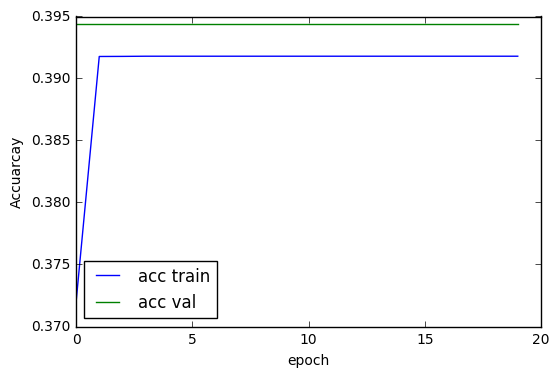

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'],label = 'acc train')
plt.plot(history.history['val_acc'],label = 'acc val')



plt.xlabel("epoch")
plt.ylabel("Accuarcay")

plt.legend(loc='best')
plt.show()
